In [1]:
# pip install kaggle

In [2]:
# !mv kaggle.json /root/.kaggle/kaggle.json

In [3]:
# !kaggle datasets download -d quentinletellier/bapst-data-static-structure-in-glasses

In [4]:
# !pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cu117.html

In [5]:
# !pip install torch_geometric

In [6]:
# import zipfile
# from zipfile import ZipFile

In [7]:
# zip = ZipFile('bapst-data-static-structure-in-glasses.zip')
# zip.extractall()

In [8]:
# !pip install pandas matplotlib torchmetrics

In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import torch
from torch import nn as nn
from torch.nn import MSELoss
import torch.nn.functional as F
import torchmetrics
from torchmetrics import MeanSquaredError,PearsonCorrCoef
#!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric --no-index --find-links=file:///torch-geometric
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data,Dataset
from torch_geometric.nn import GCNConv, GATConv,global_mean_pool,GATv2Conv
from torch_geometric.nn.norm import BatchNorm
from torch.optim.lr_scheduler import StepLR,ExponentialLR
from torchmetrics import R2Score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt
import os
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
dataset=[]
for i in range(0,400):
    dataset.append(torch.load("graphs/graph"+str(i)+".pt"))
    dataset[i].x=dataset[i].x.type(torch.float32)
    dataset[i].edge_attr=dataset[i].edge_attr.type(torch.float32)

In [11]:
dataset[0]

Data(x=[4096, 1], edge_index=[2, 167710], edge_attr=[167710, 3], y=[4096, 1], pos=[4096, 3], e_pot=0, pair_pot=0, edge_targets=[167710, 1], delta_r_cage=[4096, 1])

In [12]:
train_loader=DataLoader(dataset[:350],batch_size=10,shuffle=True)
test_loader=DataLoader(dataset[350:],batch_size=10,shuffle=False)

In [13]:
device

device(type='cuda')

In [14]:
pearson_correr=PearsonCorrCoef().to(device)
r2_scorer=R2Score().to(device)

In [15]:
r2_scores=[]
pearson_correlations=[]

In [16]:
def evaluate():
    model.eval()
    outs=torch.empty(0).to(device)
    ys=torch.empty(0).to(device)
    for data in test_loader:
        data=data.to(device)
        out=model(data)
        outs=torch.cat((outs,out.flatten()))
        ys=torch.cat((ys,data.y.flatten()))
        #data.cpu()
    pearson=pearson_correr(outs,ys)
    r2=r2_scorer(outs,ys)
    pearson_correlations.append(pearson.item())
    r2_scores.append(r2.item())
    return pearson.item(),r2.item()

In [17]:
class GATCONVModel(torch.nn.Module):
    def __init__(self,hidden_dim_encode=32,hidden_dim_conv=7,attention_heads=5,dropout_rate=0.1):
        super(GATCONVModel,self).__init__()
        torch.manual_seed(46)
        self.encoder= nn.Sequential(
            nn.Linear(3,hidden_dim_encode),
            nn.ReLU(),
            nn.Linear(hidden_dim_encode,hidden_dim_encode),
            nn.ReLU(),
            nn.Linear(hidden_dim_encode,hidden_dim_encode),
            nn.ReLU()
        )
        self.conv1=GATConv(1,hidden_dim_conv,heads=attention_heads,dropout=dropout_rate,edge_dim=hidden_dim_encode)
        self.conv2=GATConv(hidden_dim_conv*attention_heads,hidden_dim_conv,heads=attention_heads,dropout=dropout_rate,edge_dim=hidden_dim_encode)
        self.conv3=GATConv(hidden_dim_conv*attention_heads,hidden_dim_conv,heads=attention_heads,dropout=dropout_rate,edge_dim=hidden_dim_encode)
        self.conv4=GATConv(hidden_dim_conv*attention_heads,hidden_dim_conv,heads=attention_heads,dropout=dropout_rate,edge_dim=hidden_dim_encode)
        self.decoder=nn.Sequential(
            nn.Linear(hidden_dim_conv*attention_heads,hidden_dim_encode),
            nn.ReLU(),
            nn.Linear(hidden_dim_encode,hidden_dim_encode),
            nn.ReLU(),
            nn.Linear(hidden_dim_encode,1)
        )
        
    def forward(self,data):
        x,edge_index,edge_attr=data.x,data.edge_index,data.edge_attr
        edge_attr=self.encoder(edge_attr)
        x=self.conv1(x,edge_index,edge_attr)
        x=self.conv2(x,edge_index,edge_attr)
        x=self.conv3(x,edge_index,edge_attr)
        x=self.conv4(x,edge_index,edge_attr)
        x=self.decoder(x)
        return x

In [18]:
def get_gradients(model):
    grads = []
    for params in model.parameters():
        grads.append(torch.max(torch.abs(params)).item())
    return grads

In [19]:
loss_fn=MSELoss()
model=GATCONVModel().to(device)
optimizer=torch.optim.Adam(model.parameters(),lr=0.01,weight_decay=0.0) #weight_decay=1e-5
scheduler = StepLR(optimizer,step_size=20, gamma=0.5)
train_losses=[]
test_losses=[]
for epoch in range(100):
    if epoch%1==0 and epoch!=0:
        pearson_print,r2_print=evaluate()
        print("epoch:",epoch,"| loss:",train_losses[-1]," | pearson_corr:",pearson_print," | r2_score:",r2_print)
    batch_losses=[]
    model.train()
    for data in train_loader:
        data=data.to(device)
        optimizer.zero_grad()
        out=model(data)
        loss=loss_fn(out,data.y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm=1.0,foreach=True)
        optimizer.step()
        batch_losses.append(loss.item())
    train_losses.append(np.mean(batch_losses))
    
    model.eval()
    batch_losses=[]
    for data in test_loader:
        data=data.to(device)
        out=model(data)
        loss=loss_fn(out,data.y)
        batch_losses.append(loss.item())
    test_losses.append(np.mean(batch_losses))
    scheduler.step()

epoch: 1 | loss: 0.1290621363690921  | pearson_corr: -0.005934921558946371  | r2_score: -0.0007454156875610352
epoch: 2 | loss: 0.09529443851539067  | pearson_corr: 0.08674740046262741  | r2_score: -0.0004056692123413086
epoch: 3 | loss: 0.09496401931558336  | pearson_corr: 0.15715910494327545  | r2_score: 0.0018177032470703125
epoch: 4 | loss: 0.09362748797450747  | pearson_corr: 0.21927085518836975  | r2_score: -0.005318403244018555
epoch: 5 | loss: 0.09067853816917965  | pearson_corr: 0.3273441791534424  | r2_score: 0.09661227464675903
epoch: 6 | loss: 0.08343019038438797  | pearson_corr: 0.5381021499633789  | r2_score: 0.27865660190582275
epoch: 7 | loss: 0.07093530244060925  | pearson_corr: 0.5921263098716736  | r2_score: 0.3327319622039795
epoch: 8 | loss: 0.06775398765291486  | pearson_corr: 0.6218026876449585  | r2_score: 0.3276064395904541
epoch: 9 | loss: 0.06620440844978605  | pearson_corr: 0.6203995943069458  | r2_score: 0.3824838399887085
epoch: 10 | loss: 0.06421076793755

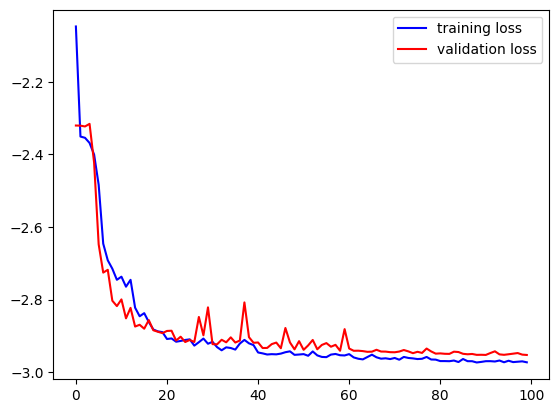

In [20]:
plt.plot(np.log(train_losses),color='blue')
plt.plot(np.log(test_losses),color='red')
plt.legend(["training loss","validation loss"])
plt.show()

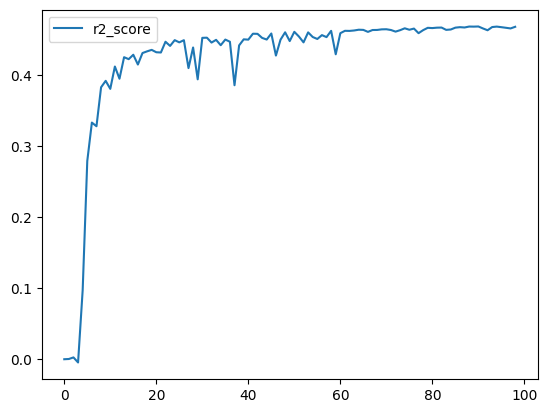

In [21]:
plt.plot(r2_scores)
plt.legend(["r2_score"])
plt.show()

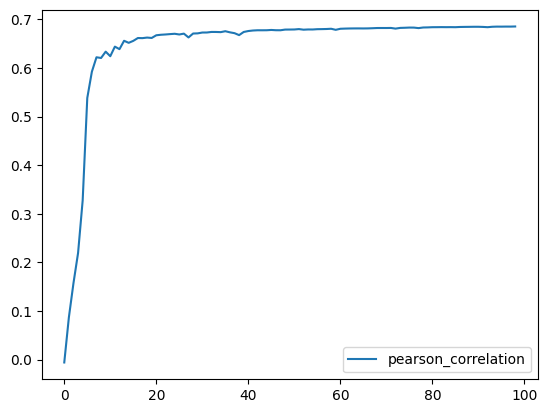

In [22]:
plt.plot(pearson_correlations)
plt.legend(["pearson_correlation"])
plt.show()

In [23]:
final_results=evaluate()
print("Pearson_Corr=",final_results[0],"| R2_Score=",final_results[1])

Pearson_Corr= 0.6853156685829163 | R2_Score= 0.46824193000793457
